In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import re
import string
from wordcloud import WordCloud
from collections import Counter

import warnings
warnings.filterwarnings('ignore')


from nltk.stem import PorterStemmer
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import string
punctuations = list(string.punctuation)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, svm

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#from scikitplot.metrics import plot_confusion_matrix, plot_roc

import tensorflow as tf

from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
import time
from keras.layers import Dense, Input, Flatten, LSTM, Bidirectional,Embedding, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential, load_model
from keras import losses
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.preprocessing.sequence import pad_sequences
#from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/matteomorellini/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matteomorellini/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('mental_health.csv')
data.head()

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


In [4]:
data.isnull().sum()

text     0
label    0
dtype: int64

In [5]:
data['label'].value_counts()

label
0    14139
1    13838
Name: count, dtype: int64

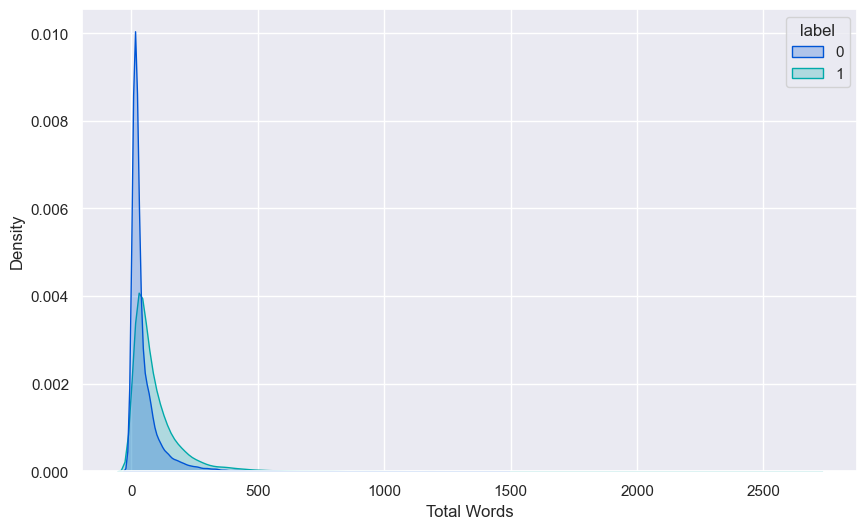

In [6]:
data['Total Words'] = data['text'].apply(lambda x: len(x.split()))

def count_total_words(text):
    char = 0
    for word in text.split():
        char += len(word)
    return char

data['Total Chars'] = data["text"].apply(count_total_words)
plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Words'], hue= data['label'], palette= 'winter', shade = True)
plt.show()

##Text Pre-processing

1. Lowercase

In [7]:
def convert_lowercase(text):
    text = text.lower()
    return text

data['text'] = data['text'].apply(convert_lowercase)

2. Removing URLs

In [8]:
def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

data['text'] = data['text'].apply(remove_url)

3. Punctuations

In [9]:
exclude = string.punctuation

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

data['text'] = data['text'].apply(remove_punc)

4. Remove stopwords

In [10]:
stopwrds =  list(stopwords.words('english'))
def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)

    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

data['text'] = data['text'].apply(remove_stopwords)

5. Stemming

In [11]:
stemmer = PorterStemmer()

def perform_stemming(text):
    new_list = []
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return " ".join(new_list)

data['text'] = data['text'].apply(perform_stemming)

In [12]:
data['Total Words After Transformation'] = data['text'].apply(lambda x: np.log(len(x.split())))

In [13]:
data.head()

,text,label,Total Words,Total Chars,Total Words After Transformation
0,dear american teen question dutch person heard...,0,23,112,3.135494
1,noth look forward lifei dont mani reason keep ...,1,20,98,2.944439
2,music recommend im look expand playlist usual ...,0,64,387,4.110874
3,im done tri feel betterth reason im still aliv...,1,100,493,4.574711
4,worri year old girl subject domest physicalmen...,1,311,1819,5.690359


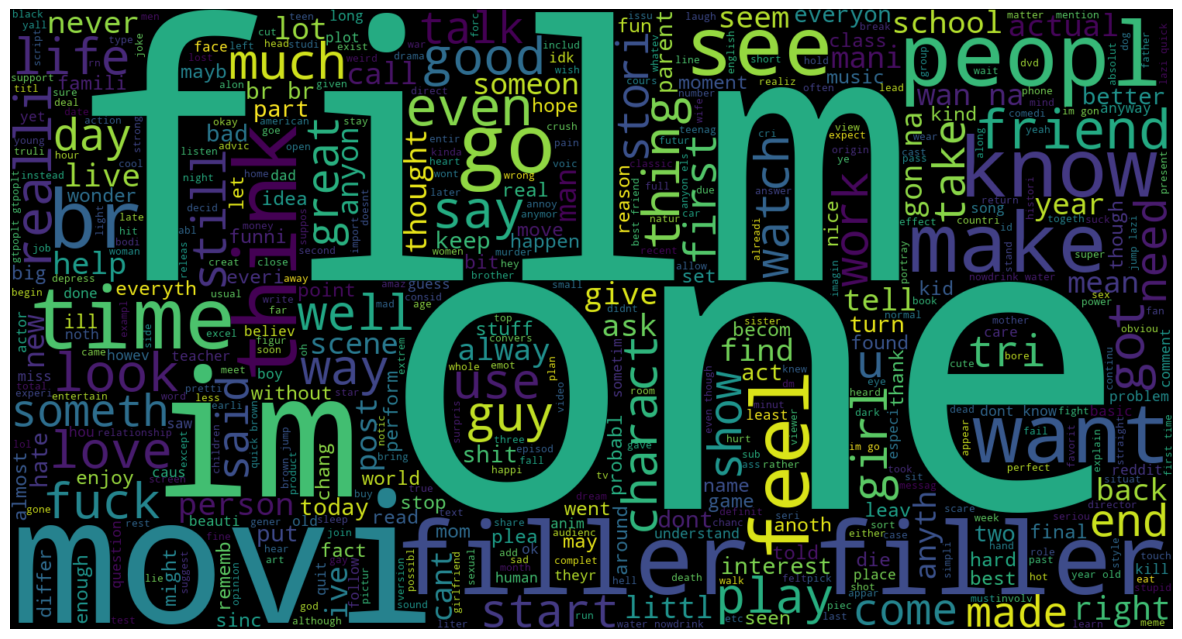

In [14]:
text = " ".join(data[data['label'] == 0]['text'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

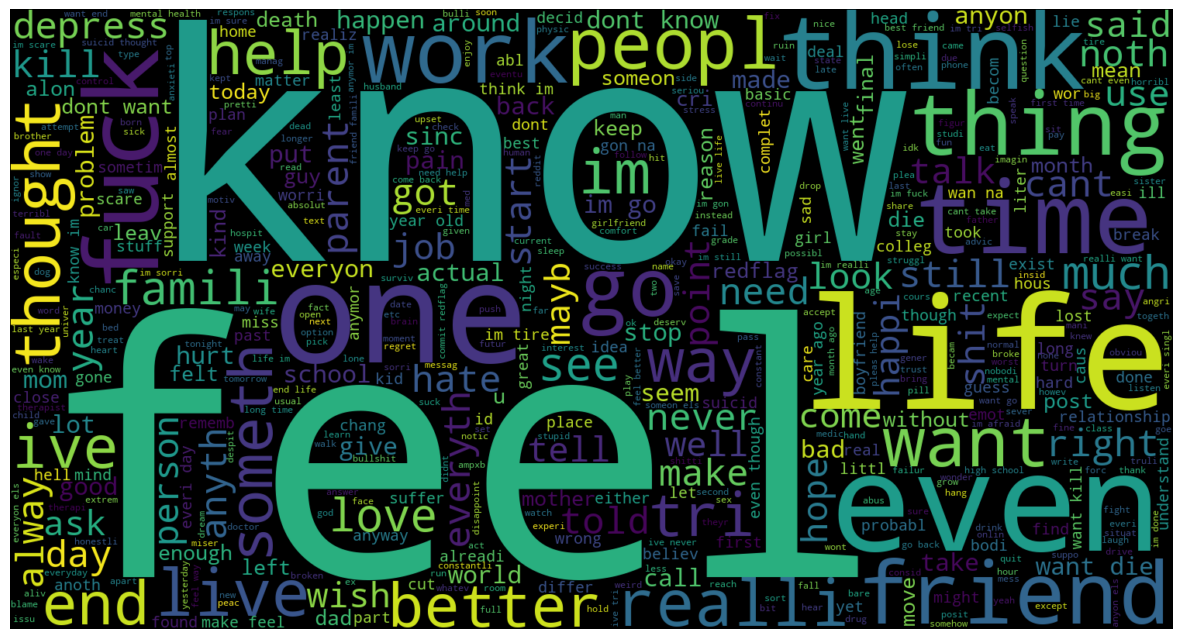

In [ ]:
text = " ".join(data[data['label'] == 1]['text'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

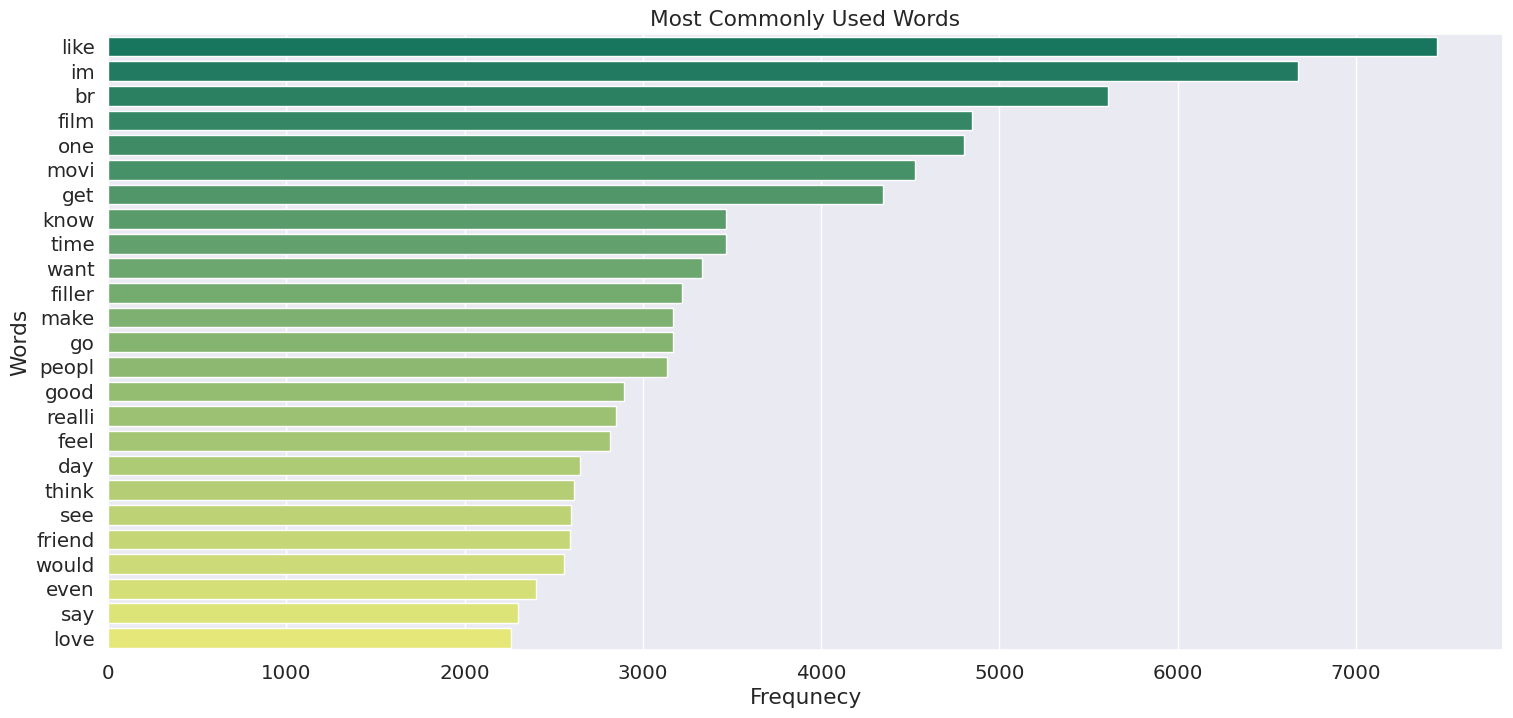

In [14]:
all_spam_words = []
for sentence in data[data['label'] == 0]['text'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)

df = pd.DataFrame(Counter(all_spam_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Words")
plt.xlabel("Frequnecy")
plt.ylabel("Words")
plt.show()

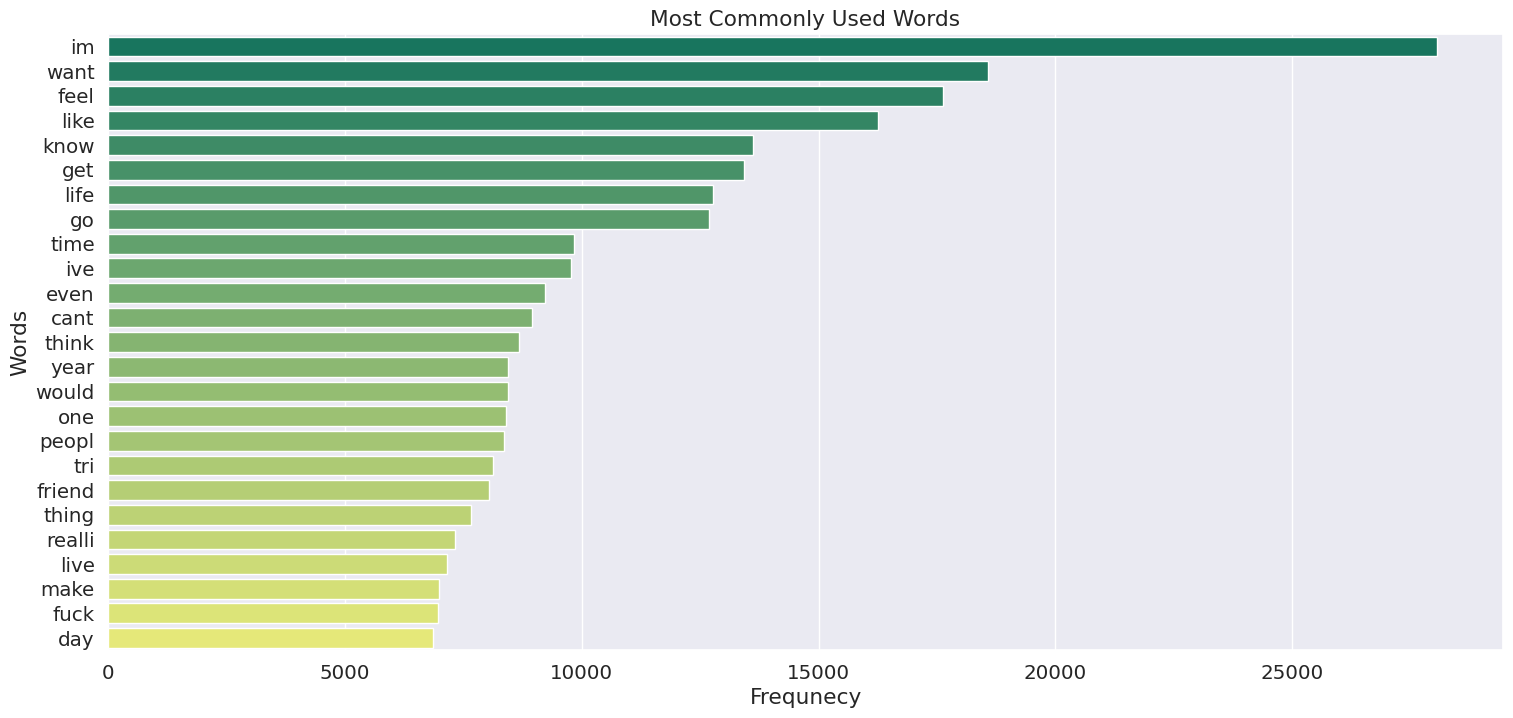

In [15]:
# code by "Spam Classifier | NLP | 98% Accuracy" by ANUBHAV GOYAL( https://www.kaggle.com/code/sasakitetsuya/spam-nlp-98-accuracy )

all_spam_words = []
for sentence in data[data['label'] == 1]['text'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)

df = pd.DataFrame(Counter(all_spam_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Words")
plt.xlabel("Frequnecy")
plt.ylabel("Words")
plt.show()

There are 54825 unique words


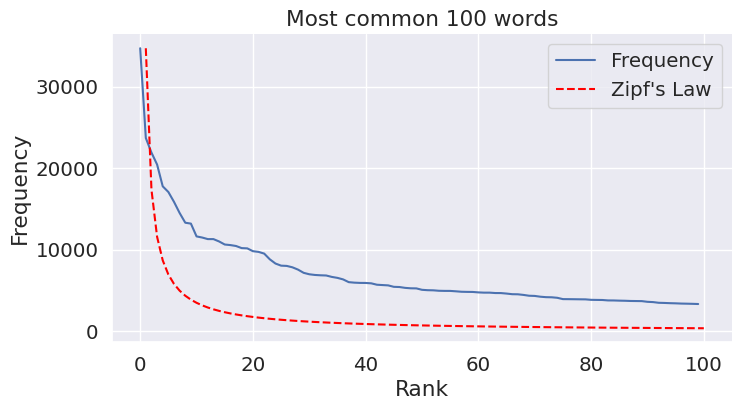

In [19]:
# @title Frequency of words
all_spam_words = []
for sentence in data['text'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)
unique_words = len(set(all_spam_words))
print("There are", unique_words, "unique words")
df = pd.DataFrame(Counter(all_spam_words).most_common(100), columns= ['Word', 'Frequency'])

from matplotlib import pyplot as plt
df['Frequency'].plot(kind='line', figsize=(8, 4), title='Most common 100 words')
plt.gca().spines[['top', 'right']].set_visible(False) #Hide the top and right spines of the plot for a cleaner look.
ranks = range(1, len(df) + 1)
zipf_frequencies = [df['Frequency'].iloc[0] / r for r in ranks]

# Add Zipf's law to the plot
plt.plot(ranks, zipf_frequencies, linestyle='--', color='red', label="Zipf's Law")
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.legend()

### Modeling


Tf-idf with Naive Bayes

In [ ]:
data.head()

,text,label,Total Words After Transformation
0,dear american teen question dutch person heard...,0,3.135494
1,noth look forward lifei dont mani reason keep ...,1,2.944439
2,music recommend im look expand playlist usual ...,0,4.110874
3,im done tri feel betterth reason im still aliv...,1,4.574711
4,worri year old girl subject domest physicalmen...,1,5.690359


In [3]:
X = data["text"]
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify = y)

TfidfVectorizer combines Count Vectorizer and TfIdf Transformer: TfIdfVectorizer performs both term frequency (TF) counting and the IDF (inverse document frequency) transformation in a single step. It essentially combines the functionalities of CountVectorizer and TfIdfTransformer without the need of a term-document matrix

In [ ]:
tfidf = TfidfVectorizer(max_features= 2500, min_df= 2)
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

In [ ]:
def train_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)

    print(f'Accuracy of the model: {accuracy}')
    print(f'Precision Score of the model: {precision}')
    print(f'Recall Score of the model: {recall}')

    #sns.set_context('notebook', font_scale= 1.3)
    #fig, ax = plt.subplots(1, 2, figsize = (25,  8))
    #ax1 = plot_confusion_matrix(y_test, y_pred, ax= ax[0], cmap= 'YlGnBu')
    #ax2 = plot_roc(y_test, y_prob, ax= ax[1], plot_macro= False, plot_micro= False, cmap= 'summer')

In [ ]:
nb = MultinomialNB()
train_model(nb)

Accuracy of the model: 0.888
Precision Score of the model: 0.839
Recall Score of the model: 0.957


Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators= 300)
train_model(rf)

Accuracy of the model: 0.891
Precision Score of the model: 0.88
Recall Score of the model: 0.903


SVD

In [ ]:
def train_SVD_model(n_dims):
  # Apply SVD decomposition to the tfidf matrix
  # Truncate matrix U of SVD
  svd = TruncatedSVD(n_components=n_dims)
  X_train_SVD = svd.fit_transform(X_train)
  X_test_SVD = svd.transform(X_test)
  classifier = LogisticRegression()
  classifier.fit(X_train_SVD, y_train)
  y_pred = classifier.predict(X_test_SVD)
  y_prob = classifier.predict_proba(X_test_SVD)
  accuracy = round(accuracy_score(y_test, y_pred), 3)
  precision = round(precision_score(y_test, y_pred), 3)
  recall = round(recall_score(y_test, y_pred), 3)

  print(f'Accuracy of the model: {accuracy}')
  print(f'Precision Score of the model: {precision}')
  print(f'Recall Score of the model: {recall}')

In [ ]:
train_SVD_model(1000)
#Negative values in data passed to MultinomialNB (input X)
#Multinomial Naive Bayes (MultinomialNB) is a variant of the Naive Bayes classifier that is particularly suited for classification with discrete feature vectors, such as word counts in text classification. It is based on the multinomial distribution, which models the probability of observing counts of various outcomes in a fixed number of trials

Accuracy of the model: 0.916
Precision Score of the model: 0.926
Recall Score of the model: 0.903


Word2Vec

In [ ]:
max_words = 5000
max_len = 100

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequences of integers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer
def tokenize_sequences(text):
  pol_text = []
  for sentence in text:
    pol_text.append(word_tokenize(sentence.lower()))
  return pol_text

print('Before Tokenization & Padding \n', data['text'][0],'\n')
#X, tokenizer = tokenize_pad_sequences(data['text'])
X = tokenize_sequences(data['text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 dear american teen question dutch person heard guy get way easier thing learn age us sooooo thth grader like right guy learn math 

After Tokenization & Padding 
 ['dear', 'american', 'teen', 'question', 'dutch', 'person', 'heard', 'guy', 'get', 'way', 'easier', 'thing', 'learn', 'age', 'us', 'sooooo', 'thth', 'grader', 'like', 'right', 'guy', 'learn', 'math']


In [ ]:
from multiprocessing import cpu_count

cpu = cpu_count()
print('The virtual instance has {} cpus, that will be used to train the word2vec model'.format(cpu))

print("Training the W2V ...")
pol = Word2Vec(X, vector_size=100, window=5, min_count=3, workers=cpu)
pol.train(X, total_examples=len(X), epochs=5)
pol_wv = pol.wv

The virtual instance has 8 cpus, that will be used to train the word2vec model
Training the W2V ...


In [ ]:
from sklearn.manifold import TSNE
def reduce_dimensions(model):
    num_components = 2  # numero di dimensioni da mantenere in seguito alla compressione

    # estraiamo il vocabolario dal modello e i vettori in modo da associarli nel grafico
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    # applichiamo TSNE
    tsne = TSNE(n_components=num_components, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


def plot_embeddings(x_vals, y_vals, labels):
    import plotly.graph_objs as go
    fig = go.Figure()
    trace = go.Scatter(x=x_vals, y=y_vals, mode='markers', text=labels)
    fig.add_trace(trace)
    fig.update_layout(title="Word2Vec - Visualizzazione embedding con TSNE")
    return fig


In [ ]:
x_vals, y_vals, labels = reduce_dimensions(pol)
plot_embeddings(x_vals, y_vals, labels)

In [ ]:
def closest_to(w, n=10):
    if w in pol_wv:
      closest_ws =[w[0] for w in pol_wv.most_similar(w, topn=n)]
      print("the closest {}, words to \"{}\" "
      "are: \n {}".format(n, w, '"'+'",\n then "'.join(closest_ws)+'"'))
    else:
      print(w, " could not be found in the vocabulary")

In [ ]:
closest_to('scissor')

the closest 10, words to "scissor" are: 
 "nail",
 then "cord",
 then "itch",
 then "blade",
 then "taker",
 then "cutter",
 then "whip",
 then "butter",
 then "scratch",
 then "bruis"


In [ ]:
pol.wv.doesnt_match(['scissor', 'knot', 'bestfriend'])

'bestfriend'

In [ ]:
#result = pretrained_vectors.most_similar(positive=['woman', 'king'], negative=['man']) --> king-man+woman
#prozac:insomnia=?:anxiety --> prozac - insomnia + anxiety --> another medicine?
result = pol_wv.most_similar(positive=['bestfriend', 'girl'], negative=['friend'], topn=1)
print("Most similar word:", result)
result = pol_wv.most_similar(positive=['prozac', 'anxieti'], negative=['insomnia'], topn=1)
print("Most similar word:", result)

Most similar word: [('hookup', 0.5903047919273376)]
Most similar word: [('antidepress', 0.6079398989677429)]


###Train from scratch section

LSTM

In [9]:
X = data["text"]
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify = y)

In [10]:
X_train

10544    hiya leav messag repli wake day took break day...
13576    come friend follow right anyon know irl see hi...
27344    artist struggl life sure look formayb convers ...
2001     shoutout unnecessarili strict thing parent som...
22864    set date august th realli feel anyth anymor ti...
                               ...                        
2954                                im good mood final lol
17975    go divorc bankruptci look lose homei bought wa...
26730    think romanc movi help coupl develop deeper ap...
5149     desper femal one interest relationship femal w...
10888    dont get happeningim usual dead insid dont usu...
Name: text, Length: 22381, dtype: object

In [11]:
with open("sentences.txt", "w", encoding="utf-8") as f:
    for sentence in X_train:
        f.write(sentence + "\n")

In [12]:
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers import decoders
#In this way we keep the previous pre-processing (with also stemming)

vocab_size=30000
tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
tokenizer.decoder = decoders.WordPiece() #responsible for decoding token IDs back into human-readable tokens or text

#we can set various special tokens useful for handling specific cases if needed.
trainer = WordPieceTrainer(vocab_size=vocab_size,
                     special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"])

train_file = "./sentences.txt"
files = [train_file]
tokenizer.train(files, trainer)

saved_tokenizer = "./tokenizer-recipe.json"
tokenizer.save(saved_tokenizer)

In [26]:
output_example = tokenizer.encode("i lov math")
print(output_example.tokens)
print(output_example.ids)
print(tokenizer.decode(output_example.ids))

['i', '## ', '##lov ', '##mat', '##h']
[15, 38, 4926, 4115, 44]
i lov math


In [15]:
import torch
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from transformers import PreTrainedTokenizerFast
from tokenizers.implementations import BaseTokenizer
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
from einops import rearrange, pack, unpack
from torchinfo import summary
import numpy
import random
from torcheval.metrics.functional.text import perplexity

#SETTING THE RANDOM SEED
#############################################
#as a good behavior when training neural networks, it is important to set the seed for random number generators for reproducibility purposes!
#######################################
def set_seed(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.random.manual_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed = 0
set_seed(seed)

#HYPER-PARAMETERS SETTING.
#IN OUR CASE, THE EMBEDDING DIMENSIONALITY MUST BE THE SAME OF THE PRETRAINED ONE.
embedding_dim= 512
learning_rate=1e-4
#BATCH SIZE NEEDS TO FIT THE NEURAL NETWORK IN GPU MEMORY
batch_size = 16
#THE MODEL SHOULD BE TRAINED FOR MORE TIME, BUT FOR COMPUTATIONAL REASON AND AS AN EXAMPLE WE WILL ONLY USE FEW EPOCHS
nb_epoch=10
train_path = "./sentences.txt"
saved_tokenizer = "./tokenizer-recipe.json"
saving_model_path= "./myNLM_ep"

In [34]:
#FOR FAST TOKENIZATION WE CAN USE THE FAST TOKENIZER LIBRARY
tokenizer = Tokenizer.from_file(saved_tokenizer)

#Enabling padding with the right chosen index
pad_id = tokenizer.token_to_id("[PAD]")
print("PAD ID: "+str(pad_id))
tokenizer.enable_padding(pad_id=pad_id, pad_token="[PAD]")

#we can use a fast version of our tokenizer
fast_tokenizer = PreTrainedTokenizerFast(tokenizer_object=tokenizer)
#we can set the cut-off threshold for how long (i.e. how many words in a sentence) we want to handle our sentences
fast_tokenizer.model_max_length = 200

vocab_size = len(fast_tokenizer)
print("VOCABULARY SIZE: "+str(vocab_size))
padding_idx = fast_tokenizer.pad_token_id
print("CHECK PADDING IDX: "+str(padding_idx))

PAD ID: 0
VOCABULARY SIZE: 30000
CHECK PADDING IDX: 0


THIS HAS TO BE MODIFIED SINCE IT PREDICTS THE NEXT WORD

In [35]:
import torch.nn as nn

class NLM(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, padding_idx):
        super(NLM, self).__init__()

        #https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
        self.embedding_layer = nn.Embedding(num_embeddings, embedding_dim, padding_idx=padding_idx)

        #https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM
        self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size = embedding_dim, num_layers=2, batch_first=True)

        #https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
        self.to_logits = nn.Linear(embedding_dim, num_embeddings)

    def forward(self, input_ids):

        embs = self.embedding_layer(input_ids)
        #print(embs.shape)
        lstm_out, (h_n, c_n) = self.lstm(embs)
        #print(lstm_out.shape)
        logits = self.to_logits(lstm_out)
        #print(logits.shape)
        return logits



In [40]:
dataset = pd.DataFrame(X_train, columns=["text"])


In [48]:
dataset = []
#TOKENIZE THE FULL TRAINING DATA
def tokenize_data(example):
    return fast_tokenizer(example, truncation=True)

for sentence in X_train:
    dataset.append(tokenize_data(sentence))
#print(dataset)




dear american teen question dutch person heard guy get way easier thing learn age us sooooo thth grader like right guy learn math
{'input_ids': [1], 'token_type_ids': [0], 'attention_mask': [1]}



In [58]:
#FOR TRAINING REASON WE NEED TO CONSTRUCT BATCH OF SENTENCES WITH THE SAME LENGTH
#AS EACH SENTENCE HAS A VARIABLE LENGTH, WE NEED TO "PAD" THE SENTENCES TO A FIXED LENGTH
#THE FOLLOWING UTILITY WILL DO THAT FOR US.
#EXAMPLE WITH A BATCH OF 2 SENTENCES:
# INPUT:
# [START] this is a very long sentence . [END]
# [START] this is a sentence . [END]
# #lengths = 9 words the first sentence, and 7 words the second one.
# OUTPUT:
# [START] this is a very long sentence . [END]
# [START] this is a sentence . [END] [PAD] [PAD]
# #lengths = 9 words both first and second sentence.
datacollator = DataCollatorWithPadding(tokenizer=fast_tokenizer)

dataloader_train = DataLoader(dataset, batch_size=batch_size, drop_last=False, shuffle=True, collate_fn=datacollator)

nlm_model = NLM(vocab_size, embedding_dim, padding_idx)
#nlm_model.cuda()
#PRINT THE MODEL ARCHITECTURE
summary(nlm_model)

Layer (type:depth-idx)                   Param #
NLM                                      --
├─Embedding: 1-1                         15,360,000
├─LSTM: 1-2                              4,202,496
├─Linear: 1-3                            15,390,000
Total params: 34,952,496
Trainable params: 34,952,496
Non-trainable params: 0

In [60]:
optimizer = torch.optim.Adam(nlm_model.parameters(), lr=learning_rate)

cnt = 0
for epoch in range(nb_epoch):
    print("EPOCH "+str(epoch))
    for item in tqdm(dataloader_train):#, disable=True):
        optimizer.zero_grad()
        #input_ids = item['input_ids'].to('cuda')
        input_ids = item['input_ids']
        inp, target = input_ids[:, :-1], input_ids[:, 1:]

        output_logits = nlm_model(inp)

        loss = F.cross_entropy(
            rearrange(output_logits, 'b n c -> b c n'),
            target
        )
        loss.backward()
        optimizer.step()
        cnt+=1
        if cnt%100==0:
            print("\niter: "+str(cnt))
            print("loss:")
            print(loss)
            ppl = perplexity(output_logits, target)
            print("perplexity:")
            print(ppl)

    #saving a checkpoint after each epoch
    torch.save(nlm_model.state_dict(), saving_model_path + str(epoch)+ ".pt")

EPOCH 0


  3%|▎         | 47/1399 [01:01<29:23,  1.30s/it]


KeyboardInterrupt: 

###Pre-trained model

In [16]:
import pandas as pd

In [17]:
data = pd.read_csv('mental_health.csv')
X = data["text"]
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify = y)
X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, test_size=0.2, random_state = 42)

In [18]:
from transformers import AutoTokenizer

#model_name = "distilbert/distilbert-base-cased"
model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(sentence):
    return tokenizer(sentence, padding=True, truncation=True)


tokenized_X_train=[]
for i, sentence in enumerate(X_train):
    tokenized_X_train.append({**tokenize_function(sentence), **{"label": y_train[i], "text": sentence}})

tokenized_X_dev = []
for i, sentence in enumerate(X_dev):
    tokenized_X_dev.append({**tokenize_function(sentence), **{"label": y_dev[i], "text": sentence}})

In [56]:
from torch.utils.data import Dataset
import torch
class CustomDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        item = self.data_list[idx]
        input_ids = torch.tensor(item['input_ids'])
        attention_mask = torch.tensor(item['attention_mask'])
        label = torch.tensor(item['label'])
        text = item['text']
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': label,
            'text': text
        }
custom_X_train = CustomDataset(tokenized_X_train)
custom_X_dev = CustomDataset(tokenized_X_dev)

In [52]:
from transformers import AutoModelForSequenceClassification

print(model_name)
num_labels = 2
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, id2label=id2label, label2id=label2id)

distilbert/distilbert-base-uncased


In [53]:
from sklearn.metrics import accuracy_score

def get_accuracy(preds):
  preds_preds = preds.predictions[0] if isinstance(preds.predictions, tuple) else preds.predictions
  predictions = preds_preds.argmax(axis=-1)
  labels = preds.label_ids
  accuracy = accuracy_score(preds.label_ids, preds_preds.argmax(axis=-1))
  return {'accuracy': accuracy}

In [54]:
from transformers import TrainingArguments

batch_size = 16
epochs = 1
logging_steps = len(X_train) // batch_size
model_name_output_dir = model_name.replace("/", "-")+"-finetuned-imdb"
training_args = TrainingArguments(output_dir=model_name_output_dir,
                                  num_train_epochs=epochs,
                                  learning_rate=1e-4,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  optim='adamw_torch'
                                  )

In [57]:
from transformers import Trainer

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=get_accuracy,
                  train_dataset=custom_X_train,
                  eval_dataset=custom_X_dev,
                  tokenizer=tokenizer)
trainer.train()

KeyboardInterrupt: 

In [19]:
from datasets import load_dataset
imdb = load_dataset("imdb")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [20]:
imdb.pop('unsupervised')
seed = 0
#Let's get a small portion from the training to create a dev set
train_and_dev = imdb["train"].train_test_split(test_size=0.05, seed=seed, shuffle=True)
print(train_and_dev)

#Let's update the dataset with the new split that includes the dev data
imdb["dev"] = train_and_dev["test"]
imdb["train"] = train_and_dev["train"]
print(imdb)
seed = 0
#Let's reduce also the test data to 5k sample only
test_and_discard = imdb["test"].train_test_split(test_size=0.2, seed=seed, shuffle=True)
print(test_and_discard)

#Let's update the test partition
imdb["test"] = test_and_discard["test"]
print(imdb)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 23750
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1250
    })
})
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 23750
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    dev: Dataset({
        features: ['text', 'label'],
        num_rows: 1250
    })
})
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
})
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 23750
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
    dev: Dataset({
        features: ['text', 'label'],
        num_rows: 1250
    })
})


In [21]:
from transformers import AutoTokenizer

#model_name = "distilbert/distilbert-base-cased"
model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

imdb_encoded = imdb.map(tokenize_function, batched=True, batch_size=None)

# Show the sentence, the different tokens and the corresponding numerical ids
print(imdb_encoded['train'][0])

{'text': 'Is it a coincidence that Orca was made two years after Jaws? Orca isn\'t exactly a "Jaws rip off" but it is obvious that it tried to profit from Jaws\'s success. First of all Orca in my opinion was a bad movie, not terrible but definitely not good, average at best.<br /><br />The plot is basically a male killer whale (orca) after seeing its mate and its unborn calf killed by a fisherman seeks revenge. I couldn\'t stand to watch this movie again. The direction of this film is poor and when compared to Jaws it looks like the director, producers, and writers were almost talentless.<br /><br />As for the acting, it was very average and believable, however the actual characters aren\'t the least bit likable. The effects were alright for its time and the footage of the killer whale looked pretty good.<br /><br />The violence is confusing, bloody, and not recommended for more sensitive people. The music is overdone and very loud, drowning out the sound effects and irritating at time

In [22]:
from transformers import AutoModelForSequenceClassification

print(model_name)
num_labels = 2
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, id2label=id2label, label2id=label2id)

distilbert/distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
from sklearn.metrics import accuracy_score

def get_accuracy(preds):
  preds_preds = preds.predictions[0] if isinstance(preds.predictions, tuple) else preds.predictions
  predictions = preds_preds.argmax(axis=-1)
  labels = preds.label_ids
  accuracy = accuracy_score(preds.label_ids, preds_preds.argmax(axis=-1))
  return {'accuracy': accuracy}

In [24]:
from transformers import TrainingArguments

batch_size = 16
epochs = 1
logging_steps = len(imdb_encoded["train"]) // batch_size
model_name_output_dir = model_name.replace("/", "-")+"-finetuned-imdb"
training_args = TrainingArguments(output_dir=model_name_output_dir,
                                  num_train_epochs=epochs,
                                  learning_rate=1e-4,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  optim='adamw_torch'
                                  )

In [11]:
from transformers import Trainer

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=get_accuracy,
                  train_dataset=imdb_encoded["train"],
                  eval_dataset=imdb_encoded["dev"],
                  tokenizer=tokenizer)
trainer.train()

 17%|█▋        | 259/1485 [13:55<1:21:34,  3.99s/it]

KeyboardInterrupt: 